# Predicting Firm-Level Loss Behaviour and Corporate Income Tax (CIT) Revenue Risk in Kenya


### Authors

Brian Kahiu, John Karanja, Cyrus Mutuku, Catherine Gachiri, Fredrick Nzeve, Grace Kinyanjui, Jeremy Onsongo


### Background Information

The Kenya Revenue Authority (KRA), established in 1995, is responsible for collecting all national government revenue. Corporate Income Tax (CIT) is levied at 30% for resident companies and non-residents under the Income Tax Act, with sector-specific incentives available through Special Economic Zones (SEZs), Capital Deductions and Export Processing Zones (EPZs).

Companies must file annual CIT returns (ITC2 form) electronically via the iTax platform within six months of their accounting year-end, supported by valid electronic Tax Invoice Management System (eTIMS) invoices. Taxable income is calculated as gross income less allowable business expenses. A company is considered tax resident if incorporated in Kenya or if management and control is exercised locally.

### Business Problem Definition

Kenya has persistently failed to meet Corporate Income Tax (CIT) revenue targets. The high prevalence of firms reporting losses significantly erodes the effective tax base, creating fiscal deficit. The central problem is the lack of an empirical, data-driven framework for:

1. Identifying which firm-level characteristics are associated with loss reporting.
2. Proactively identifying high-risk firms and sectors.
3. Assessing how firm-level loss behavior translates into systemic CIT revenue risk.

### Our Solution

An automated risk scoring system that:

1. Processes firm-level CIT return data using the methodology outlined in the project proposal.
2. Employs an iterative modeling approach, beginning with interpretable logistic regression as a primary benchmark.
3. Applies machine learning to identify high-risk loss-reporting firms for targeted compliance.

### Project Objectives

***General Objective***

To predict the probability of a firm reporting a loss

***Specific Objectives***

1. To empirically identify firm-level characteristics associated with loss reporting in CIT returns.
2. To develop a supervised predictive model estimating the probability of a firm reporting a loss.
3. To assess the concentration and distribution of loss behavior across sectors and firm groups.
4. To translate firm-level loss probabilities into insights on aggregate CIT revenue risk.

### Methodology

This project follows the Cross-Industry Standard Process for Data Mining (CRISP-DM) to ensure a structured, transparent, and policy-relevant analytics workflow.

### Business Understanding

Stakeholder needs were identified, the business problem was defined, and success metrics were established to align analytical outputs with compliance and fiscal objectives.

### Data Understanding

Corporate Income Tax return data for 2024 were explored to assess structure and data quality.


### Primary Stakeholders

1. KRA Compliance Directors

- Problem: Manual audit selection misses high-risk loss-reporting firms
- Need: Prioritize firms with highest evasion probability for investigation
- Business Value: Improved audit efficiency and revenue recovery

2. Tax Policy Analysts at National Treasury

- Problem: Revenue forecasting uncertainty due to loss declaration patterns

- Need: Data-driven risk assessment for fiscal planning and budgeting

- Business Value: Improved accuracy in CIT revenue projections

3. Field Tax Officers

- Problem: Wasted time on low-risk audits with minimal revenue recovery

- Need: Focus investigations on firms with highest probability of tax avoidance

- Business Value: Higher productivity and improved targeting outcomes

###  Data Description
The analysis uses 2024 Corporate Income Tax return data containing 313,870 firm-year observations across 61 variables (47 numeric, 14 categorical). The dataset includes financial data, sector classifications, and firm characteristics from administrative filings.

###  Modeling Scope Definition

Validity: Retain only active businesses with positive turnover

Target: Flag firms as "Risk" (is_loss = 1) if Profit Before Tax is negative

Sector Standardization: Clean sector names and consolidate rare sectors

### Success Metrics

-Model performance assessed using AUC-ROC, precision, recall, and F1-score.

-Validation follows a time-based split to reflect real-world forecasting conditions.

-Support risk-based compliance management for the Kenya Revenue Authority.

-Provide clearer understanding of structural weaknesses in the CIT base for the National Treasury.

-Inform policy discussions on capital allowances, financing structures, and related-party transactions.




### 1.0 Import the necessary libraries

We import the key libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Machine learning Preprocessing & Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf


# Machine learning Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, precision_recall_curve, brier_score_loss, log_loss
)

# Model saving
import joblib

# System utilities
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


### 2.0 Data loading and Initial Checks
Here, we imported the raw tax data and examined its basic structure.

In [2]:
df = pd.read_csv("CIT2024.csv", low_memory=False)
df.shape

(313870, 61)

In [3]:
df.info()
print(df.dtypes.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313870 entries, 0 to 313869
Data columns (total 61 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   unique_id                      313870 non-null  float64
 1   business_type                  313870 non-null  object 
 2   business_subtype               310874 non-null  object 
 3   epz_effective_dt               149 non-null     object 
 4   period_from                    313870 non-null  object 
 5   period_to                      313870 non-null  object 
 6   filing_date                    313870 non-null  object 
 7   is_nil_return                  313870 non-null  object 
 8   return_type                    313870 non-null  object 
 9   assmt_type                     313870 non-null  object 
 10  eff_dt_com_activity            85 non-null      object 
 11  sector                         313862 non-null  object 
 12  division_                     

In [4]:
df.head(5)

,unique_id,business_type,business_subtype,epz_effective_dt,period_from,period_to,filing_date,is_nil_return,return_type,assmt_type,...,prof_loss_tax_div_bal_st,empexp__salary_wages,init_plant_mach_allow,init_indu_buld_allow,cap_allw_indu_buld,wear_tear_dedc_rbm,wear_tear_dedc_slm,deduct_agri_land,tot_allow_deductions,avg_no_of_employees
0,1.210000e+09,Company,Private Company,NaN,1/1/2024,31/12/2024,27/06/2025,N,Original,S,...,8191.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.210001e+10,Company,Private Company,NaN,1/1/2024,31/12/2024,27/06/2025,Y,Original,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1.210002e+10,Company,Private Company,NaN,1/1/2024,31/12/2024,27/05/2025,N,Original,S,...,151384.13,250000.0,0.0,0.0,0.0,1853.1,0.0,0.0,1853.1,NaN
3,1.210002e+10,Company,Private Company,NaN,1/1/2024,31/12/2024,20/05/2025,Y,Original,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.210002e+10,Company,Private Company,NaN,1/1/2024,31/12/2024,29/06/2025,N,Original,S,...,114704.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### 2.1 Missing Values and Duplicate Check

- We checked for missing values and duplicates 

In [5]:
# 1. Duplicate check
print("Duplicated Rows",df.duplicated().sum())

# 2. Missing values check
df.isnull().mean().mul(100).round(3).sort_values(ascending=False)
print("Top 10 columns with missing values in percentage (%)")
print(df.isnull().mean().mul(100).round(3).sort_values(ascending=False).head(10))


Duplicated Rows 3011
Top 10 columns with missing values in percentage (%)
eff_dt_com_activity             99.973
epz_effective_dt                99.953
income_tax_exp                  96.193
avg_no_of_employees             80.814
class_                          65.182
prof_loss_tax_div_bal_st        64.151
insurance_comp                  64.151
oi_dividend                     64.151
oi_commision                    64.151
oi_natural_resource_payments    64.151
dtype: float64


The analysis revealed that missing values were concentrated in a small subset of columns, while most variables maintained high completeness.

### 2.2 Initial Data Cleaning Actions
Based on the findings from the previous executions.

In [6]:
# Store original dataset before any cleaning
original_rows = df.shape[0]
original_cols = df.shape[1]

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
remove_duplicates = original_rows - df.shape[0]
print(f"Original: {original_rows:,} rows, {original_cols} columns")
print(f"Current: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Duplicates removed: {remove_duplicates:,}")

Original: 313,870 rows, 61 columns
Current: 310,859 rows, 61 columns
Duplicates removed: 3,011


In [7]:
# Check for columns with high missing values after dropping duplicates
missing_pct = df.isna().mean()
high_missing_cols = missing_pct[missing_pct > 0.60].index.tolist()
print(f"{len(high_missing_cols)} columns with more than 60% missing values")

49 columns with more than 60% missing values


### 3. Standardisation and Core Field Alignment

From the initial checks, the dataset is largely numeric and structurally usable after removing duplicates. Missing values however, are highly concentrated in a subset of fields, especially incentive-related indicators (e.g, EPZ fields) and several detailed cost components. Before feature engineering, we standardise key categorical fields (notably sector) and align the core accounting fields required for modelling (turnover, costs, profit). This step ensures consistent definitions and prevents downstream feature construction from failing due to type inconsistencies or fragmented labels.

We also explicitly tag variables with high missing values for exclusion from modelling, rather than attempting to impute variables that are effectively absent for most firms.

In [8]:
# Sector standardization
df['sector'] = df['sector'].astype(str).str.strip().str.upper()

df["sector"] = df["sector"].replace("nan", "Unknown")
df["sector"] = df["sector"].replace("None", "Unknown")
df["sector"] = df["sector"].replace("", "Unknown")

# Collapse very rare sectors into "Other" for Stability
counts = df["sector"].value_counts()
rare_sectors = counts[counts < 100].index.tolist()
df["sector"] = df["sector"].replace(rare_sectors, "Other")

print("Sector summary (top 10):")
print(df["sector"].value_counts().head(10))

Sector summary (top 10):
sector
CONSTRUCTION                                                            47476
SERVICE ACTIVITIES                                                      44699
WHOLESALE AND RETAIL TRADE, REPAIR OF MOTOR VEHICLES AND MOTORCYCLES    36937
ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES                           25403
AGRICULTURE, FORESTRY AND FISHING                                       22814
REAL ESTATE ACTIVITIES                                                  21240
PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES                       14341
INFORMATION AND COMMUNICATION                                           14227
EDUCATION                                                               10921
FINANCIAL AND INSURANCE ACTIVITIES                                      10679
Name: count, dtype: int64


In [9]:
# Align core accounting fields
TURNOVER_COL = "grossturnover"
PROFIT_COL = "profit_loss_before_tax"
DEDUCT_COL = "tot_allow_deductions"

# Convert core accounting fields to numeric
required = [TURNOVER_COL, PROFIT_COL, DEDUCT_COL]
for col in required:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print({"turnover": TURNOVER_COL, "profit": PROFIT_COL, "deductions": DEDUCT_COL})

{'turnover': 'grossturnover', 'profit': 'profit_loss_before_tax', 'deductions': 'tot_allow_deductions'}


The core financial columns above were converted to numeric data type for easier data manipulation

### 4. Target Construction and Modeling scope

We construct the loss indicator from profit before tax and restrict the modeling sample to firms with valid financial information. Only records with non-missing, positive turnover and non-missing profit are retained. At this stage, no columns are dropped beyond those required to define the modeling scope. Feature selection will be handled during feature engineering

In [10]:
# Construct target variable
df["is_loss"] = (df["profit_loss_before_tax"] < 0).astype(int)

print("Full data loss rate:", round (df["is_loss"].mean(), 3))

Full data loss rate: 0.143


The output above showcases that out of the full list of firms in the dataset, 14.3% of firms recorded a loss

In [11]:
# Restrict to valid financial records
initial_shape = df.shape

df_model = df.dropna(subset=["grossturnover", "profit_loss_before_tax"]) 
df_model = df_model[df_model["grossturnover"] > 0]
df_model = df_model.copy()

print("Values before restriction:", initial_shape)
print("Values after restriction:", df_model.shape)
print("Loss rate after restriction:", round(df_model["is_loss"].mean(), 3))

Values before restriction: (310859, 62)
Values after restriction: (99491, 62)
Loss rate after restriction: 0.36


Before restricting the data, we recorded 310,859 firms and after the restriction, the number of firms went down to 99,491. The restriction was made to drop null values in the gross turnover and profit_loss_before_tax columns and ensure that the values present in gross turnover are more than zero. This was done to refine the data for future modeling

In [12]:
# statistical check on the retained sample (financial records)
print(df_model[["grossturnover", "profit_loss_before_tax"]].describe())

       grossturnover  profit_loss_before_tax
count   9.949100e+04            9.949100e+04
mean    1.103211e+08            8.909992e+06
std     2.455305e+09            5.416955e+08
min     1.000000e-02           -1.445469e+10
25%     9.126625e+05           -9.991150e+04
50%     4.421440e+06            1.948400e+04
75%     1.909908e+07            4.291495e+05
max     5.699210e+11            1.381260e+11


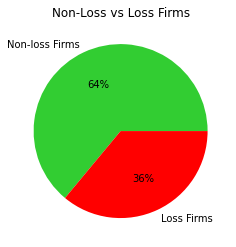

In [13]:
# Visualisation on loss VS non-loss distribution
loss_counts = df_model["is_loss"].value_counts().sort_index()
sizes = loss_counts.values

labels = ["Non-loss Firms", "Loss Firms"]
my_colors = ["limegreen", "red"]

plt.pie(sizes, labels=labels, colors=my_colors,autopct='%1.0f%%')
plt.title("Non-Loss vs Loss Firms")
plt.show()

With the above visualisation, we noted that our transformed dataset now had roughly a 60-40 split on Non-loss to Loss-making firms respectively. This is a relatively well balanced data set, and will not require executing class balancing using SMOTE.

### Feature Engineering (Model inputs)

Having defined the modeling sample and confirmed a materially higher incidence of Non loss-making firms, we now proceed to feature engineering. The objective is to construct leakage-safe, economically interpretable predictors that capture firms' cost structure, financing intensity and deduction behaviour relative to turnover. The engineered features form the core inputs to the predictive models and allow loss outcomes to be explained in terms of underlying business characteristics rather than accounting results.

In [14]:
# Core column names
turnover = "grossturnover"
cost_sales = "cost_of_sales"
admin = "total_administrative_exp"
employment = "total_employment_exp"
finance = "total_financing_exp"
deductions = "tot_allow_deductions"

# Coverting the columns above to numeric
columns_to_fix = [turnover, cost_sales, admin, employment, finance, deductions]

for col in columns_to_fix:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

#Avoid dividing by zero to avoid errors
df_model[turnover] = df_model[turnover].replace(0, np.nan)

We proceed with creating the financial ratios. Financial ratios are essential as they give us an idea of the financial status of the firms in the sample.

In [15]:
# Calculating the ratios
df_model["cost_to_turnover"] = df_model[cost_sales] / df_model[turnover] 
df_model["admin_cost_ratio"] = df_model[admin] / df_model[turnover]
df_model["employment_cost_ratio"] = df_model[employment] / df_model[turnover]
df_model["finance_cost_ratio"] = df_model[finance] / df_model[turnover]
df_model["deductions_to_turnover"] = df_model[deductions] / df_model[turnover]

df_model["high_cost_flag"] = (df_model["cost_to_turnover"] > 0.90).astype(int)  #Structural Flags
df_model["thin_margin_flag"] = df_model["cost_to_turnover"].between(0.95, 1.05).astype(int)



# Checking the missing values & Statistical summary of the ratios
engineered = [
    "cost_to_turnover", "admin_cost_ratio",
    "employment_cost_ratio", "finance_cost_ratio",
    "deductions_to_turnover", "high_cost_flag", "thin_margin_flag"
]


display("Missing values in calculated ratios in percentage:", df_model[engineered].isnull().mean().mul(100).to_frame())
display(df_model[["cost_to_turnover", "admin_cost_ratio","employment_cost_ratio", "finance_cost_ratio","deductions_to_turnover"]].describe().round(3))

'Missing values in calculated ratios in percentage:'

,0
cost_to_turnover,0.0
admin_cost_ratio,0.0
employment_cost_ratio,0.0
finance_cost_ratio,0.0
deductions_to_turnover,0.0
high_cost_flag,0.0
thin_margin_flag,0.0


,cost_to_turnover,admin_cost_ratio,employment_cost_ratio,finance_cost_ratio,deductions_to_turnover
count,9.949100e+04,9.949100e+04,9.949100e+04,9.949100e+04,9.949100e+04
mean,2.057767e+04,2.863134e+04,2.459367e+04,3.738625e+03,5.727830e+03
std,5.368381e+06,3.690745e+06,3.515659e+06,5.939724e+05,7.533600e+05
min,-1.512180e+04,0.000000e+00,0.000000e+00,-2.110000e-01,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.920000e-01,7.000000e-03,0.000000e+00,2.000000e-03,0.000000e+00
75%,8.580000e-01,1.080000e-01,4.900000e-02,1.300000e-02,1.200000e-02
max,1.658951e+09,8.747519e+08,8.622341e+08,1.412476e+08,1.523438e+08


In [16]:
# Creating quartiles (turnover bins)
df_model["turnover_bin_q"] = pd.qcut(df_model["grossturnover"], 4, labels=["Q1", "Q2", "Q3", "Q4"]) # qcut ranks the data set in ascending order based on the turnover, and splits the arrange data into 4 equal quartiles

# Looking at loss rate by turnover quartile
# grouping the data by quartiles
loss_by_q = (df_model.groupby("turnover_bin_q")["is_loss"].mean().mul(100).round(1).to_frame("loss_rate_%"))
display(loss_by_q)

,loss_rate_%
turnover_bin_q,
Q1,41.1
Q2,41.7
Q3,33.9
Q4,27.4


Based on the distribution of firms by the quartiles, we can conclude that for the firms in Q1 (firms with low grossturnover), they reflect that 41.1% of them report losses. On the other hand, large firms (Q4), only a few of them (27.4%) reported losses in the dataset.

The distribution of loss rate by quartile is also visualised in a bar graph below.

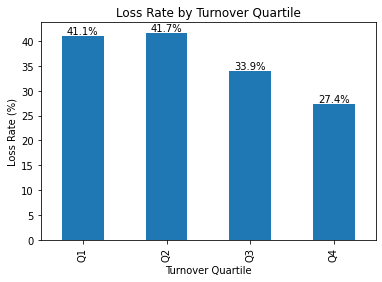

In [17]:
#Visualize the distribution of loss by turnover quartile on a bar graph
ax =loss_by_q.plot(kind='bar', legend=False)
plt.title("Loss Rate by Turnover Quartile")
plt.xlabel("Turnover Quartile")
plt.ylabel("Loss Rate (%)")

# For data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.show()

### 6.Outlier Handling & Feature Stabilisation

The engineered features contained some extreme values, mostly driven by tiny turnover figures or data inconsistencies. To prevent these outliers from skewing our model, we applied a standard cleaning process.

We cap all ratio variables at the 1st and 99th percentiles. We also apply basic logic checks, for instance, removing negative ratios where they don't make sense. We record all these cutoff points to ensure the process is transparent and reproducible. 

In [18]:
# Outlier Handling (Winsorisation)
#   - Cap extreme ratio values to improve model stability
#   - Keep rules transparent and reproducible


RATIO_COLS = [
    "cost_to_turnover",
    "admin_cost_ratio",
    "employment_cost_ratio",
    "finance_cost_ratio",
    "deductions_to_turnover"
]

# Enforce basic economic plausibility before winsorising
df_model.loc[df_model["cost_to_turnover"] < 0, "cost_to_turnover"] = np.nan
df_model.loc[df_model["finance_cost_ratio"] < 0, "finance_cost_ratio"] = np.nan  


In [19]:
# Winsorise at 1st and 99th percentiles
caps = {}
for c in RATIO_COLS:
    lo, hi = df_model[c].quantile([0.01, 0.99]).round(3)
    caps[c] = {"p01": lo, "p99": hi}  # lo represents our lower bound of our range while hi represents the upper bound of our range
    df_model[c] = df_model[c].clip(lower=lo, upper=hi)

print("Winsorisation caps (1st and 99th percentiles):")
display(pd.DataFrame(caps).T)

Winsorisation caps (1st and 99th percentiles):


,p01,p99
cost_to_turnover,0.0,2.975
admin_cost_ratio,0.0,2.718
employment_cost_ratio,0.0,1.361
finance_cost_ratio,0.0,0.952
deductions_to_turnover,0.0,1.027


From the above results, we are capping any available outliers to fall within the range of 1st to 99th percentile.The table shows the minimum and maximum limits that were used to cap extreme values in each financial ratio during winsorisation.

In [20]:
print("\nPost-winsorisation summary (min/max/mean):")
display(df_model[RATIO_COLS].describe().round(3).T[["min", "max", "mean", "std"]])


Post-winsorisation summary (min/max/mean):


,min,max,mean,std
cost_to_turnover,0.0,2.975,0.532,0.501
admin_cost_ratio,0.0,2.718,0.134,0.357
employment_cost_ratio,0.0,1.361,0.080,0.205
finance_cost_ratio,0.0,0.952,0.034,0.123
deductions_to_turnover,0.0,1.027,0.035,0.131


After winsorisation, the minimum value of all ratios is Zero with the highest ratio of 2.975 for cost_to_turnover.This indicates that Cost_to_turnover ratio is the most volatile ratio with a mean of 0.532 and a standard deviation of 0.501.

In [21]:
# Drop minimal and explicit rows
before = df_model.shape[0]
df_model = df_model.dropna(subset=RATIO_COLS).copy()
after = df_model.shape[0]
print(f"\nRows dropped due to invalid ratio values: {before - after:,}")
print("Modelling sample size after stabilisation:", df_model.shape)


Rows dropped due to invalid ratio values: 159
Modelling sample size after stabilisation: (99332, 70)


The dataset is now clean and ready for modeling.

### 7. Saving the Final Clean Dataset

After winsorisation, we visually inspect the stabilised ratio features to confirm that extreme values have been controlled and distributions are suitable for modelling. We then freeze the modelling dataset used in all subsequent analysis to ensure full reproducibility.


The cost-to-turnover ratio has the highest average (0.532) and variability, indicating greater dispersion in overall costs relative to revenue. Administrative and employment cost ratios show moderate spread, reflecting differences in operational and staffing structures across entities. Finance costs and deductions ratios exhibit the lowest means and standard deviations, suggesting these expenses are typically minimal and more stable after outlier treatment.

### 8. Handling Missing Values in the Modeling Pipeline
Although the engineered features contain no missing values, the modeling pipeline explicitly includes imputation to ensure robustness and reproducibility. This safeguards the analysis against residual or future missingness and guarantees that all models are trained under consistent, production-ready preprocessing rules.

In [22]:
# Post-stabilisation diagnostics
RATIO_COLS = [
    "cost_to_turnover",
    "admin_cost_ratio",
    "employment_cost_ratio",
    "finance_cost_ratio",
    "deductions_to_turnover"
]

# Summary statistics by loss status
stats = (
    df_model
    .groupby("is_loss")[RATIO_COLS]
    .agg(["mean", "median", "std"])
)

# Rename loss indicator
stats.index = stats.index.map({0: "Non-loss", 1: "Loss"})

print("Summary statistics by loss status (post-winsorisation):")
display(stats)


Summary statistics by loss status (post-winsorisation):


cost_to_turnover                     admin_cost_ratio            \
                     mean    median       std             mean    median   
is_loss                                                                    
Non-loss         0.453607  0.527941  0.392967         0.076049  0.002779   
Loss             0.672016  0.685160  0.626187         0.237059  0.028679   

                   employment_cost_ratio                  finance_cost_ratio  \
               std                  mean median       std               mean   
is_loss                                                                        
Non-loss  0.210801              0.053018    0.0  0.142346           0.023830   
Loss      0.505999              0.126862    0.0  0.277261           0.051625   

                             deductions_to_turnover                   
            median       std                   mean median       std  
is_loss                                                               
Non-loss  0.001281  0.093651               0.019004    0.0  0.081372  
Loss      0.003453  0.161059               0.063861    0.0  0.186087

In [23]:
#Save final modeling dataset

FEATURES = [
    "cost_to_turnover",
    "admin_cost_ratio",
    "employment_cost_ratio",
    "finance_cost_ratio",
    "deductions_to_turnover",
    "high_cost_flag",
    "thin_margin_flag",
    "turnover_bin_q",
    "sector"
]
FINAL_COLS = FEATURES + ["is_loss"]

final_clean = df_model[FINAL_COLS].copy()

final_clean.to_csv("final_modeling_dataset.csv", index=False)
print("Final modeling dataset shape:", final_clean.shape)
print("Columns used for modeling:")
print(final_clean.columns.tolist())
print("Saved: final_clean.csv")

Final modeling dataset shape: (99332, 10)
Columns used for modeling:
['cost_to_turnover', 'admin_cost_ratio', 'employment_cost_ratio', 'finance_cost_ratio', 'deductions_to_turnover', 'high_cost_flag', 'thin_margin_flag', 'turnover_bin_q', 'sector', 'is_loss']
Saved: final_clean.csv


***8. Handling Missing Values in the Modeling Pipeline***

Although the engineered features contain no missing values, the modeling pipeline explicitly includes imputation to ensure robustness and reproducibility. This safeguards the analysis against residual or future missing values and guarantees that all models are trained under consistent, production-ready preprocessing rules.

### Preprocessing with Explicit Missing-Value Handling using Onehot encoding

In [24]:
# Feature groups
num_vars = [                               #dealing with our numerical variables
    "cost_to_turnover",
    "admin_cost_ratio",
    "employment_cost_ratio",
    "finance_cost_ratio",
    "deductions_to_turnover",
    "high_cost_flag",
    "thin_margin_flag"
]

cat_vars = ["turnover_bin_q", "sector"]    # dealing with our Categorical variables through imputation

# Numeric pipeline                           
num_pipeline = Pipeline([                                   
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])



in the above output, "turnover_bin_q" and "sector" have been treated as categorical values where one hot encoding will be performed in the code cell below.

### Creating Pipelines for Numerical and Categorical values

In [25]:
# Numeric pipeline  
ohe = OneHotEncoder
num_pipeline = Pipeline([                                   
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])
    

The pipeline prepares numerical features for modeling through imputation and replacing missing 
numerical values with the median.

On the other hand, the categorical pipeline prepares categorical features for modeling by imputing the
most_frequent value to the missing values. One hot encoding has also been used to convert categorical values to numeric which takes the form of (0/1).

### EXPLORATORY  DATA ANALYSIS

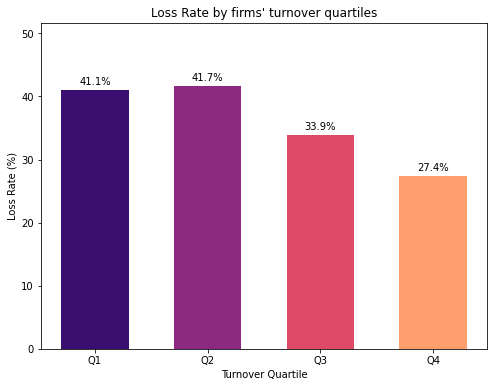

In [26]:
# Loss rate by turnover quartile
loss_by_quartile = ( final_clean.groupby("turnover_bin_q")["is_loss"].mean().mul(100).round(1).to_frame("loss_rate"))

plt.figure(figsize=(8,6))
colors = sns.color_palette("magma", len(loss_by_quartile))
bars = plt.bar(loss_by_quartile.index, loss_by_quartile["loss_rate"], color=colors, width=0.6)

# Add percentage labels
for bar in bars:plt.text(bar.get_x() + bar.get_width()/2,bar.get_height() + 0.5,f"{bar.get_height():.1f}%", ha='center',va='bottom')

plt.title("Loss Rate by firms' turnover quartiles")
plt.xlabel("Turnover Quartile")
plt.ylabel("Loss Rate (%)")
plt.ylim(0, loss_by_quartile["loss_rate"].max() + 10)
plt.show()


The chart shows a relationship between firm size and loss incidence. Loss rates are highest among firms in the lowest turnover quartiles and decline steadily as turnover increases, indicating that smaller firms are more likely to report losses. This may be  attributed to fixed operating costs pressures and revenue volatility. 

In [27]:
# Use lowercase  and shorten the  length of sector name for better visualization
def shorten_sector(s, max_len=35):
    s = s.lower()
    return s if len(s) <= max_len else s[:max_len].rsplit(" ", 1)[0] + "…"

# Top 10 sectors by firm count 
top_10_count = final_clean['sector'].value_counts().nlargest(10).reset_index()
top_10_count.columns = ['sector', 'firm_count']
top_10_count['sector'] = top_10_count['sector'].apply(shorten_sector)

# Top 10 sectors by loss rate
sector_loss = ( final_clean.groupby('sector')['is_loss'].mean() .mul(100) .round(1).reset_index(name='loss_rate'))
top_10_loss = sector_loss.sort_values('loss_rate', ascending=False).head(10)
top_10_loss['sector'] = top_10_loss['sector'].apply(shorten_sector)

print( "sector concentration and loss rates by sector calculated successfully")

sector concentration and loss rates by sector calculated successfully


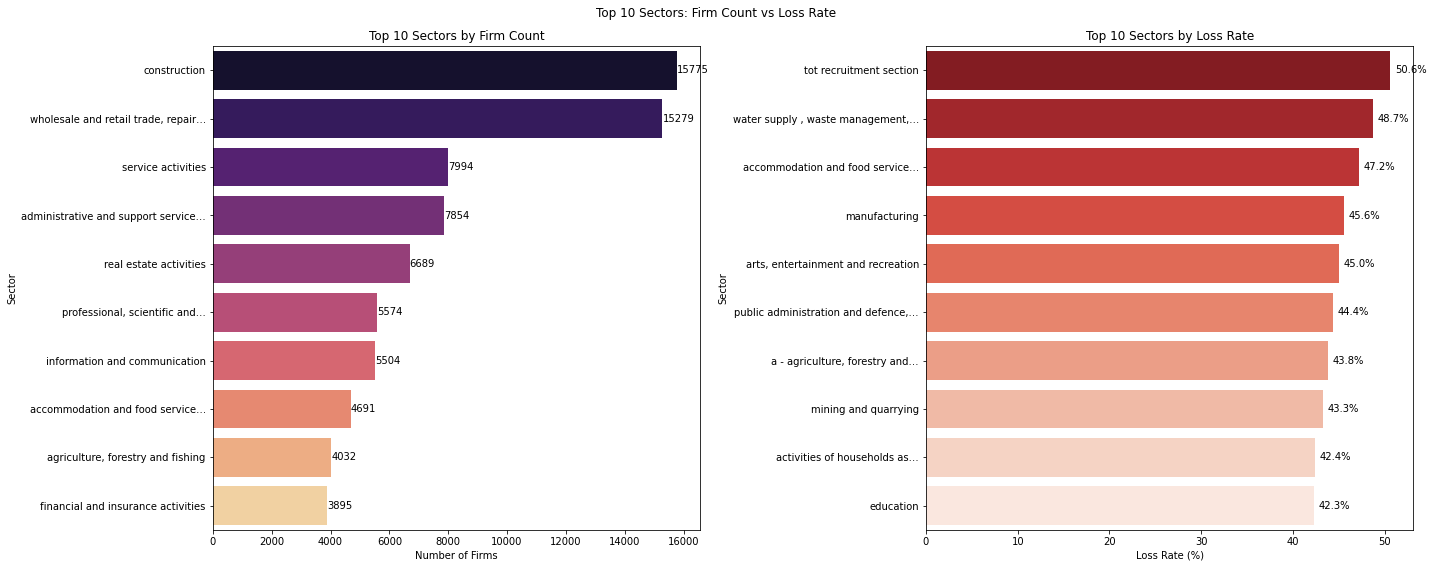

In [28]:
# plotting both graphs side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Top 10 Sectors: Firm Count vs Loss Rate")

# Panel A: Top 10 sectors by firm count
bars_count = sns.barplot(data=top_10_count, x='firm_count', y='sector', palette='magma', ax=axes[0])
axes[0].set_title("Top 10 Sectors by Firm Count")
axes[0].set_xlabel("Number of Firms")
axes[0].set_ylabel("Sector")

# Add count labels 
for bar in bars_count.patches: 
    width = bar.get_width()
    axes[0].text(width + 1, bar.get_y() + bar.get_height()/2, f"{int(width)}", va='center')

# Panel B: Top 10 sectors by loss rate
bars_loss = sns.barplot(data=top_10_loss,x='loss_rate',y='sector',palette='Reds_r', ax=axes[1])
axes[1].set_title("Top 10 Sectors by Loss Rate")
axes[1].set_xlabel("Loss Rate (%)")
axes[1].set_ylabel("Sector")

# Add percentage labels
for bar in bars_loss.patches:
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, f"{width:.1f}%", va='center')

plt.tight_layout()
plt.show()


- The panel A Chart "top ten sector by firm count"  ranks sectors purely by the number of registered firms.This hilights where economic actvity is most concentrated, such as construction and wholesale & retail trade, but it does not indicate whether firms in these sectors are profitable or loss-making. This chart shows the size of a sector.

- The Panel B Chart  "Top 10 sectors by loss rate" This ransks sectors by the %age of firms reporting losses, regardless of how many firms the sector contains. As a result, some sectors with relatively few firms appear at the top because they have a high incidence of losses. This plot is best interpreted as a measure of risk intensity and shows risker sectors interms of tunrover as depicted by loss rate.

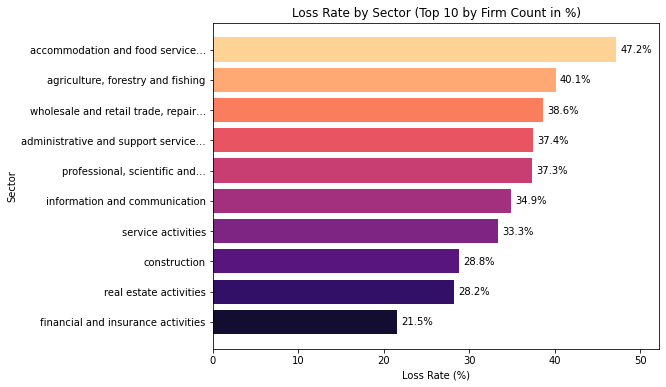

In [29]:
#  Top 10 sectors by firm count 
top_10_sectors = final_clean['sector'].value_counts().nlargest(10). index
sector_loss = ( final_clean[final_clean['sector'].isin(top_10_sectors)].groupby('sector')['is_loss'].mean().mul(100).round(1).sort_values().reset_index(name='loss_rate'))

sector_loss['sector_short'] = sector_loss['sector'].apply(shorten_sector)

plt.figure(figsize=(8,6))
colors = sns.color_palette("magma" ,   len(sector_loss))
bars = plt.barh(sector_loss['sector_short'], sector_loss['loss_rate'], color=colors)

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f"{width:.1f}%", va='center')

plt.title("Loss Rate by Sector (Top 10 by Firm Count in %)")
plt.xlabel("Loss Rate (%)")
plt.ylabel("Sector")
plt.xlim(0, sector_loss['loss_rate'].max() + 5)
plt.show()


The chart shows the loss rates  within the largest sectors. This restricts attention to sectors with many firms, it reveals which economically important sectors also exhibit elevated loss incidence. This makes it particularly useful for policy and compliance analysis, as it focuses on high-impact sectors where both scale and risk matter.

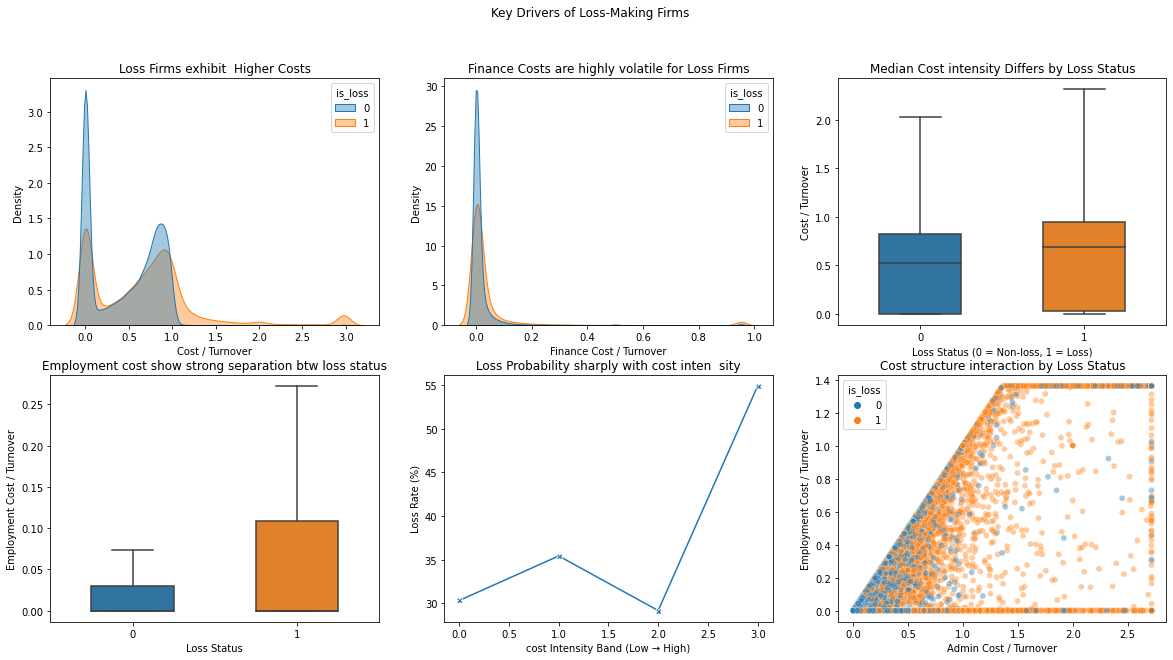

In [30]:
# Create a 2 x 3 layout for visibility of key drivers of loss-making firms

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("Key Drivers of Loss-Making Firms")
    

# Chart 1: Cost-to-turnover distribution
sns.kdeplot(data=final_clean, x="cost_to_turnover", hue="is_loss", common_norm=False, fill=True, alpha=0.4, ax=axes[0, 0])
#axes[0, 0].axvline(final_clean["cost_to_turnover"].median(),linestyle="--", linewidth=1)
axes[0, 0].set_title("Loss Firms exhibit  Higher Costs")
axes[0, 0].set_xlabel("Cost / Turnover")
axes[0, 0].set_ylabel("Density")


# Chart 2:Finance cost ratio distribution
sns.kdeplot(data=final_clean,x="finance_cost_ratio",hue="is_loss",common_norm=False,fill=True, alpha=0.4, ax=axes[0, 1])
axes[0, 1].set_title("Finance Costs are highly volatile for Loss Firms")
axes[0, 1].set_xlabel("Finance Cost / Turnover")
axes[0, 1].set_ylabel("Density")


# Chart 3: cost intensity by loss status
sns.boxplot(data=final_clean,x="is_loss",y="cost_to_turnover",width=0.5,showfliers=False,ax=axes[0, 2])
axes[0, 2].set_title("Median Cost intensity Differs by Loss Status")
axes[0, 2].set_xlabel("Loss Status (0 = Non-loss, 1 = Loss)")
axes[0, 2].set_ylabel("Cost / Turnover")


# Chart 4: Employment cost vs loss status
sns.boxplot(data=final_clean,x="is_loss",y="employment_cost_ratio",width=0.5,showfliers=False,ax=axes[1, 0])
axes[1, 0].set_title("Employment cost show strong separation btw loss status")
axes[1, 0].set_xlabel("Loss Status")
axes[1, 0].set_ylabel("Employment Cost / Turnover")


# Chart 5: Loss probability by cost bands
final_clean["cost_band"] = pd.qcut(final_clean["cost_to_turnover"],q=5,duplicates="drop")
loss_by_cost_band = (final_clean.groupby("cost_band")["is_loss"].mean().mul(100).reset_index(name="loss_rate"))
sns.lineplot( data=loss_by_cost_band, x=loss_by_cost_band.index, y="loss_rate", marker="X",ax=axes[1, 1])
colors = sns.color_palette("magma", len(loss_by_cost_band))
axes[1, 1].set_title("Loss Probability sharply with cost inten  sity")
axes[1, 1].set_xlabel("cost Intensity Band (Low → High)")
axes[1, 1].set_ylabel("Loss Rate (%)")


# Chart 6: Admin vs employment cost interaction
sns.scatterplot(data= final_clean,x="admin_cost_ratio",y="employment_cost_ratio",hue="is_loss",alpha=0.4,ax=axes[1, 2])
axes[1, 2].set_title("Cost structure interaction by Loss Status")
axes[1, 2].set_xlabel("Admin Cost / Turnover")
axes[1, 2].set_ylabel("Employment Cost / Turnover")

plt.show()


Chart 1:Loss firms exhibit structurally higher costs: Firms that make losses consistently spend more relative to their turnover than profitable firms. This pattern is seen across the full range of firms, not just extreme cases, indicating that high operating costs are a core driver of financial distress.

Chart 2: Finance cost are highly volatile for Loss Firms: while most firms have lower finance costs such as borrowing and interest rate costs, high ratios appear more often in loss firms adding volatility

Chart 3: Median cost intensity differs by Loss Status: Even the typical loss-making firm has higher costs relative to sales than a typical profitable firm. The difference is not driven by rare outliers, confirming that high costs are a consistent  issue for firms making losses.

Chart 4:Employment costs show strong separation: Loss-making firms tend to spend a higher proportion of their sales on staff costs than profitable firms. Since wages are difficult to reduce quickly, high employment costs make these firms more susceptible to losses and financial strain.

Chart 5: Loss Probability rises sharply with cost intensity The chance of making a loss increases gradually with cost levels at first but rises sharply once costs reach high levels. This highlights a threshold effect where costs become unsustainable and losses become much more likely.

Chart 6: Cost structure interaction by Loss Status: Firms with both high admin and high staff costs are much more likely to make losses. Profitable firms usually keep at least one of these costs under control, showing that combined cost pressures are particularly dangerous.

### BASIC MODEL
At this point, we run a basic logit model with two sets of variables, continous variables (ratios) and we control for sector and turnover. These are categorical variables where manufucturing sector and Q1-small firms based on turnover are the reference categories. The analysis reveals the following:

Small firms have significantly more loss probabilities than larger farms, KRA should know this in designing comliance policy
Other than education, water & sewerage and TOT sectors, all the other sectors show less losses than manufucturing sector.

Notably, there is no signifcant difference between activities of extraterritorial organizations and bodies, arts, entertainment and recreation, real estate activities, mining and mining sectors in loss probabilities as compared to manufucturing sector.

Other than thin margins, all cost ratios significantly drive loss probabilities with financial cost ratio leading

The model shows good discrimination between loss and non-loss firms (ROC-AUC = 0.736) with reasonable precision in identifying loss cases (PR-AUC = 0.653).

In [31]:
TARGET = "is_loss"
continuous = [
    "cost_to_turnover",
    "admin_cost_ratio",
    "employment_cost_ratio",
    "finance_cost_ratio",
    "deductions_to_turnover",
    "high_cost_flag",
    "thin_margin_flag",
]
dfm = df_model[[TARGET] + continuous + ["turnover_bin_q", "sector"]]
train_df, _ = train_test_split(
    dfm, test_size=0.25, stratify=dfm[TARGET]
)

formula = (
    "is_loss ~ cost_to_turnover + admin_cost_ratio + employment_cost_ratio + "
    "finance_cost_ratio + deductions_to_turnover + high_cost_flag + thin_margin_flag + "
    "C(turnover_bin_q) + C(sector)"
)


res = smf.logit(formula, data=train_df).fit(disp=False)
p_hat = res.predict(train_df)

roc = roc_auc_score(train_df[TARGET], p_hat)
pr  = average_precision_score(train_df[TARGET], p_hat)

tbl = res.summary2().tables[1][["Coef.", "Std.Err.", "z", "P>|z|"]]

tbl.index = (
    tbl.index
    .str.replace("C(turnover_bin_q)[T.", "")
    .str.replace("C(sector)[T.", "")
    .str.replace("]", "")
)
tbl = tbl.drop("MANUFACTURING", errors="ignore")

print("ROC-AUC:", round(roc, 2))
print("PR-AUC :", round(pr, 2))
display(tbl)

ROC-AUC: 0.74
PR-AUC : 0.66


,Coef.,Std.Err.,z,P>|z|
Intercept,-0.840838,0.428253,-1.963415,4.959801e-02
Q2,-0.162721,0.024437,-6.658716,2.762293e-11
Q3,-0.591562,0.025296,-23.385582,5.991443e-121
Q4,-1.148956,0.026842,-42.805167,0.000000e+00
ACCOMMODATION AND FOOD SERVICE ACTIVITIES,0.052713,0.429444,0.122748,9.023065e-01
ACTIVITIES OF EXTRATERRITORIAL ORGANIZATIONS AND BODIES,-0.138056,0.443777,-0.311094,7.557295e-01
"ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS, UNDIFFERENTIATED GOODS- AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE",-0.226399,0.432587,-0.523360,6.007237e-01
ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES,-0.378673,0.428853,-0.882990,3.772417e-01
"AGRICULTURE, FORESTRY AND FISHING",-0.229098,0.429822,-0.533007,5.940287e-01
"ARTS, ENTERTAINMENT AND RECREATION",-0.100296,0.432409,-0.231947,8.165796e-01


### Random Forest Model

To explore non-linearlities in the model, we use random forest model. The metrics accuracy and precision metrics improve to 76% and 71% respectively implying that there are non-linear relations that can't be captureed in the basic logit model.

In [32]:
X = df_model[continuous + ["turnover_bin_q", "sector"]]
y = df_model[TARGET]


X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y
)

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

p_hat = rf.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, p_hat)
pr  = average_precision_score(y_test, p_hat)

print("Random Forest ROC-AUC:", round(roc, 2))
print("Random Forest PR-AUC :", round(pr, 2))


Random Forest ROC-AUC: 0.76
Random Forest PR-AUC : 0.71


## XGBoost

### Gradient Boosting Performance

Further, we estimate a Histogram-based Gradient Boosting (HistGradientBoosting) classifier using the same training and test samples and identical preprocessing pipeline. Gradient boosting works well on tabular data.

The gradient boosting model delivers a further improvement in predictive performance, achieving:
- ROC–AUC: 0.7996 
- PR–AUC: 0.7515 

The improvement in PR–AUC is particularly relevant in the presence of a 36 per cent loss rate, signalling improved precision in identifying loss-making firms.

In [33]:
#Loading our cleaned dataset
final_clean = pd.read_csv('final_modeling_dataset.csv')

In [34]:
# Splitting features and target
X = final_clean.drop("is_loss", axis=1)
y = final_clean["is_loss"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y    #Preserves the loss/non-loss ratio
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train loss rate:", round(y_train.mean(), 3))
print("Test loss rate:", round(y_test.mean(), 3))

Train shape: (74499, 9)
Test shape: (24833, 9)
Train loss rate: 0.36
Test loss rate: 0.36


To ensure reproducibility and prevent data leakage, XGBoost is embedded within a Scikit-Learn pipeline. This allows preprocessing steps and model training to be executed consistently during cross-validation.

In [35]:
# Combine preprocessing
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_vars),
    ("cat", cat_pipeline, cat_vars)
])

# Base XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"   # faster for large datasets
)

# Full pipeline
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])

print("XGBoost pipeline ready")

XGBoost pipeline ready


- The binary logistic objective is appropriate for loss vs. profit classification
- AUC metric evaluates the model’s ability to rank loss-making firms higher than profitable ones

## Hyperparameter Optimization

Hyperparameter tuning is conducted using GridSearchCV with 3-fold cross-validation to identify the optimal model configuration.

In [ ]:
param_grid = {
    "model__n_estimators": [200, 400],   #controls the number of boosted trees
    "model__max_depth": [3, 5, 7],       #controls model complexity and helps prevent overfitting
    "model__learning_rate": [0.05, 0.1], #determines how aggressively the model corrects errors
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

# Cross-validation ensures that performance gains generalize beyond a single data split
grid = GridSearchCV(
    estimator= xgb_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=1,  
    verbose=2,
    error_score="raise"
)

grid.fit(X_train, y_train)

print("Best AUC:", round(grid.best_score_, 4))
print("Best parameters:")
print(grid.best_params_)


The tuned model is evaluated on the held-out test set to assess real-world performance

In [37]:
best_model = grid.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Core metrics
metrics = {
    "ROC AUC": roc_auc_score(y_test, y_prob),
    "Average Precision (PR-AUC)": average_precision_score(y_test, y_prob),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "Log Loss": log_loss(y_test, y_prob)}


pd.DataFrame(metrics, index=["XGBoost"]).round(4)


,ROC AUC,Average Precision (PR-AUC),Accuracy,Precision,Recall,F1 Score,Log Loss
XGBoost,0.7992,0.7517,0.7707,0.8202,0.4655,0.5939,0.489


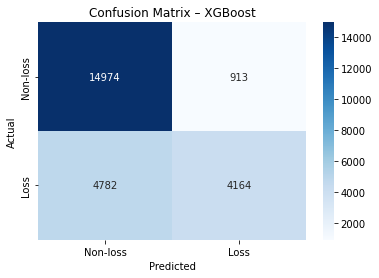

In [38]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-loss", "Loss"],
            yticklabels=["Non-loss", "Loss"])
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
# Splitting columns by type
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object", "category"]).columns.tolist()


# Preprocessing: imputing + one-hot-encoding
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# Fit on X_train, Transform X_test
Xtr = preprocess.fit_transform(X_train)
Xte = preprocess.transform(X_test)

# convert feature names to a Python list of strings
feature_names = preprocess.get_feature_names_out().astype(str).tolist()

# ensure labels are numpy arrays
ytr = np.asarray(y_train).astype(int)
yte = np.asarray(y_test).astype(int)

# DMatrix + native XGBoost with early stopping
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_names)
dtest  = xgb.DMatrix(Xte, label=yte, feature_names=feature_names)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.03,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "tree_method": "hist",
    "seed": 42
}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=3000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=False
)

print("Best iteration:", bst.best_iteration)


Best iteration: 812


In [40]:
# Model Evaluation
p_xgb = bst.predict(dtest)
print("XGB ROC-AUC:", round(roc_auc_score(yte, p_xgb), 4))
print("XGB PR-AUC :", round(average_precision_score(yte, p_xgb), 4))

# Feature importance (GAIN)
gain = bst.get_score(importance_type="gain")

imp = (
    pd.DataFrame({"feature": list(gain.keys()), "gain": list(gain.values())})
    .sort_values("gain", ascending=False)
    .head(25)
)

print("\nTop 25 Features (GAIN):")
display(imp)


XGB ROC-AUC: 0.7997
XGB PR-AUC : 0.7505

Top 25 Features (GAIN):


,feature,gain
5,num__high_cost_flag,170.670959
0,num__cost_to_turnover,40.296291
10,cat__turnover_bin_q_Q4,32.141174
17,cat__sector_CONSTRUCTION,31.028620
1,num__admin_cost_ratio,23.713602
22,cat__sector_FINANCIAL AND INSURANCE ACTIVITIES,16.540424
7,cat__turnover_bin_q_Q1,15.489515
6,num__thin_margin_flag,15.390514
8,cat__turnover_bin_q_Q2,13.358167
38,cat__sector_REAL ESTATE ACTIVITIES,12.788518


#### Feature Importance

To interpret the drivers of model predictions, feature importance is assessed using GAIN, which measures the average improvement in the model’s objective function attributable to splits on each variable. Higher GAIN values indicate variables that contribute more to reducing classification error across the boosted trees.

The top drivers of loss prediction are dominated by cost structure indicators, firm size, and sectoral affiliation, with the most influential features including:

- Cost-to-turnover ratio - the single most important predictor, highlighting the central role of cost pressure in loss outcomes.
- Sectoral effects, particularly Construction, Financial and Insurance Activities, and Manufacturing - reflecting structural differences in profitability across industries.
- Firm size (turnover quartiles) - especially the largest firms (Q4), indicating systematic differences in loss incidence across the size distribution.
- High-cost and thin-margin indicators - capturing firms operating close to viability thresholds.
- Financing and deduction intensity - pointing to the role of leverage and tax-related adjustments in shaping reported losses.


### Final Model Comparison and Selection

We evaluate the performance of all candidate models evaluated on the held-out test set. The comparison spans discrimination, classification accuracy, and calibration metrics, allowing a balanced assessment of predictive quality and operational relevance.

#### Overall Ranking
XGBoost emerges as the strongest performing model, achieving the highest scores on both primary discrimination metrics:
- ROC–AUC: 0.8001  
- PR–AUC: 0.7512  

This is followed by Random Forest and the baseline Logistic Regression model.

#### Discrimination Performance
Relative to the logistic benchmark (ROC–AUC = 0.741; PR–AUC = 0.661), tree-based models deliver clear gains in separating loss-making from non-loss-making firms. The improvement is particularly pronounced for PR–AUC, confirming that nonlinear models are materially better at identifying loss firms in a moderately imbalanced setting of 36% loss rate.

#### Classification Trade-offs
- XGBoost achieves the highest precision for loss cases of 80% indicating fewer false positives and stronger targeting efficiency, albeit with lower recall of 47%.
- Random Forest  exhibit higher recall of 71% at the cost of lower precision, implying broader but less targeted risk flags.
- Logistic Regression performs worst overall, reflecting the limitations of a purely linear specification.

These patterns highlight a clear trade-off between precision-oriented targeting (XGBoost) and recall-oriented screening (Random Forest).

#### Policy Implication
The results indicate that loss outcomes are driven by nonlinear interactions between cost structures, firm size, and sectoral characteristics. XGBoost provides the best balance between discrimination and precision, making it the preferred model for risk-based assessments.
In subsequent analysis, XGBoost is retained as the primary model, with logistic regression results serving as an interpretable benchmark.


### Model Findings

The optimised XGBoost mode delivers the strongest overall performance ROC–AUC = 80%; PR–AUC = 75%, confirming robust predictive power in a setting with a 36% loss incidence. 

Feature importance analysis shows that cost intensity and margin pressure are the dominant drivers of loss outcomes. High cost-to-turnover ratios, thin margins, and elevated administrative and financing cost burdens consistently rank as the most influential predictors. 

Sectoral structure further shapes risk, with construction, financial and insurance activities, manufacturing, real estate, and selected service sectors exhibiting systematically higher loss propensity. Firm size matters only conditionally, interacting with cost structure and sector rather than acting as an independent determinant.

Overall, the findings demonstrate that corporate loss declarations follow systematic, economically interpretable patterns, making them well-suited for risk-based modelling and policy application.

### Recommendations

- Adopt XGBoost as the operational loss-risk model, given its superior discrimination and ability to capture non-linear cost–margin and sectoral interactions.

- Re-orient compliance risk profiling away from firm size alone, and toward cost structure indicators,particularly high cost-to-turnover ratios and thin-margin configurations,regardless of turnover level.

- Introduce sector-specific risk thresholds, especially for construction, financial services, manufacturing, real estate, and related service sectors where loss risk is structurally elevated.

- Use predicted loss probabilities for risk banding, rather than binary loss flags, to support audit prioritisation, workload management, and resource allocation.

- Complement blunt policy instruments  with targeted, model-driven enforcement focused on firms exhibiting persistent and economically implausible loss patterns.

- Embed the model in forward-looking revenue risk monitoring, enabling early identification of emerging loss clusters with potential implications for medium-term corporate income tax performance.


# Deployment 
This is where we Integrate the XGBoost Loss-Risk Model into KRA’s iTax back-end 

The Workflow:
 1. Data Input:CIT returns are filed via iTax.
 2. Preprocessing: The automated pipeline applies the exact cleaning, winsorization, and ratio engineering rules.
 3. Scoring: The model assigns a Loss_Risk_Probability between 0 and 1 to every firm reporting a loss.
 4. Risk Banding: Firms are categorized into High, Medium, and Low risk based on probability thresholds.

In [41]:
# Model Serialization where we saved the artifacts using joblib
if not os.path.exists('deployment_artifacts'):
    os.makedirs('deployment_artifacts')

production_bundle = {
    "model": bst,
    "pipeline": preprocess,
    "feature_names": feature_names,
    "threshold": 0.5, 
    }


artifact_path = "deployment_artifacts/kra_cit_risk_model_v1.pkl"
joblib.dump(production_bundle, artifact_path)

print(f" Model artifacts successfully saved ")

 Model artifacts successfully saved 


In [42]:
# The Scoring Engine 
# This is the production code that KRA IT teams would deploy.  
def score_new_returns(raw_data, artifact_path):
    print("Loading model artifacts...")
    bundle = joblib.load(artifact_path)
    model = bundle["model"]
    pipeline = bundle["pipeline"]
    feats = bundle["feature_names"]
    thresh = bundle["threshold"]
    
    print("Transforming data...")
    try:
        X_processed = pipeline.transform(raw_data)
    except Exception as e:
        return {f"Error during preprocessing"}
    
    #  Convert to DMatrix which is needed by our XGBoost for data loading 
    dmatrix = xgb.DMatrix(X_processed, feature_names=feats)
    print("Scoring...")
    probs = model.predict(dmatrix)
    results = raw_data.copy()
    results["Risk_Probability"] = np.round(probs, 4)
    results["Risk_Flag"] = (probs > thresh).astype(int)
    conditions = [
        (results["Risk_Probability"] >= 0.75),
        (results["Risk_Probability"] >= 0.50),
        (results["Risk_Probability"] < 0.50)
    ]
    choices = ["Critical", "High", "Normal"]
    results["Risk_Band"] = np.select(conditions, choices, default="Normal")
    
    return results

print("Scoring engine functions defined.")

Scoring engine functions defined.
